In [1]:
import pathlib
import numpy as np
import scipy as sp
import scipy.linalg
import scipy.io
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import skimage.exposure
import skimage.feature
import skimage.restoration
import harmonica as hm
import verde as vd
import choclo
import numba
import magali as mg


In [2]:
true_inclination = 30
true_declination = 40
true_dispersion_angle = 5


size = 1000

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

amplitude=abs(np.random.normal(0, 100, size))*1.0E-14

dipole_moments = hm.magnetic_angles_to_vec(directions_inclination, directions_declination, amplitude)

print(len(directions_inclination), len(directions_declination), len(amplitude))

1000 1000 1000


In [3]:
dipole_coordinates = (
    np.random.randint(30, 1970, size), # µm
    np.random.randint(30, 1970, size), # µm
    np.random.randint(-20, -1, size) # µm
)

print(len(dipole_coordinates[0]))

1000


In [4]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

In [5]:
bz = hm.dipole_magnetic(coordinates, dipole_coordinates, dipole_moments, field="b_u")
data = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
data

<xarray.Dataset> Size: 16MB
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 8MB 0.006037 0.006107 0.006175 ... 0.005735 0.005643

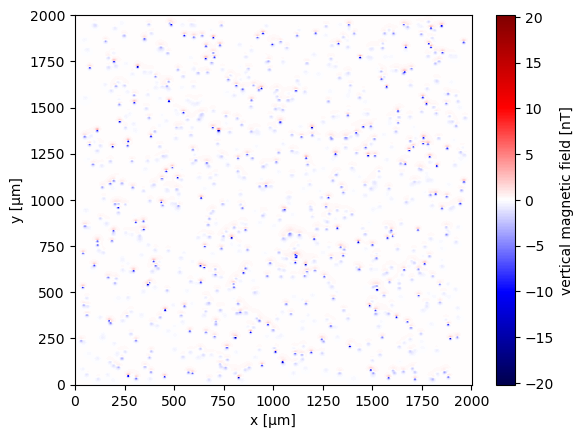

In [6]:
data.bz.plot.pcolormesh(cmap="seismic")

# Make a model like Souza-Junior's

In [7]:

sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

In [8]:
true_inclination = 30
true_declination = 40
true_dispersion_angle = 5


size = 100

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipoles_amplitude=abs(np.random.normal(0, 100, size))*1.0E-14



### Add 3 shallow sources

In [9]:
dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [ 500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([directions_inclination, [10, -10, -5]]),
    declination=np.concatenate([directions_declination, [10, 170, 190]]),
    intensity=np.concatenate([dipoles_amplitude, [5e-11, 5e-11, 5e-11]]),
)

In [10]:
# dipole_coordinates = (
#     np.random.randint(30, 1970, size), # µm
#     np.random.randint(30, 1970, size), # µm
#     # np.random.randint(-20, -1, size) # µm
# )

In [11]:
# dipole_x = np.concatenate(dipole_coordinates[0], [1250, 1300, 500])
# dipole_y = np.concatenate(dipole_coordinates[1], [ 500, 1750, 1000])
# dipole_z = np.concatenate(dipole_coordinates[2], [-15, -15, -30])

# print(len(dipole_x))
# print(len(dipole_y))
# print(len(dipole_z))

# dipole_coordinates = (dipole_x, dipole_y, dipole_z)

In [12]:
bz = hm.dipole_magnetic(coordinates, dipole_coordinates, dipole_moments, field="b_u")
data = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
data

<xarray.Dataset> Size: 16MB
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 8MB 6.974e-18 7.023e-18 ... 3.543e-18 3.509e-18

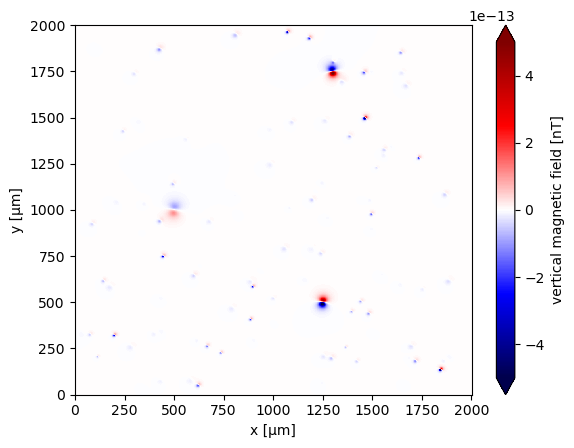

In [13]:
data.bz.plot.pcolormesh(cmap="seismic", vmin=-5000e-16, vmax=5000e-16)

# Souza-Junior's method

In [14]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

In [15]:
sourcers1 = 70
sourcers2 = 30
np.random.seed(5)

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, sourcers1),np.random.randint(30, 1970, sourcers2), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, sourcers1),np.random.randint(30, 1970, sourcers2), [ 500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, sourcers1+sourcers2), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(0, 10, sourcers2), [10, -10, -5]]),
    declination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(180, 10, sourcers2), [10, 170, 190]]),
    intensity=np.concatenate([abs(np.random.normal(0, 100, sourcers1+sourcers2))*1.0E-14, [5e-11, 5e-11, 5e-11]]),
)

# print(abs(np.random.normal(1.0E-14, 1.0E-12, sourcers)))
print(dipole_coordinates)

(array([ 897,  236, 1755, 1028, 1172, 1454,  103, 1062,  770, 1797,  441,
        654,  700, 1774, 1573,  234, 1965, 1167, 1491, 1134,   57, 1098,
        235, 1769, 1119, 1485, 1596, 1140, 1691,  176, 1308,  407, 1703,
       1416,   71, 1500, 1951,  240,  133, 1198, 1004,   35, 1880,  798,
        930, 1164,  706, 1927, 1745,  569,  829,  800,  354,  324, 1159,
        177,  304,  911,  275, 1189,  898,  394, 1675, 1724,  220, 1833,
       1545,  865, 1434, 1503,  213,  417,  633,  108,  831,  759,  883,
        421,  558, 1148,   44, 1016, 1853,  295, 1604, 1869,  174, 1443,
        448,  715, 1753,  438, 1451,  404, 1289,  774,   61, 1086,  362,
       1226, 1250, 1300,  500]), array([1955,  428,  205,  124,  880,  926, 1189, 1268,  558, 1118,  294,
       1528,   74,  668,  707,  124, 1513,  931,  775,  948,  210,  867,
       1776, 1754, 1913, 1083,  246,  662,  255,  506,  749, 1892,  577,
        909,  306,  207,  541,  614, 1726, 1264, 1067, 1274,  537,  781,
       1200, 1362

In [16]:

# bz_regional = mg.dipole_bz(coordinates, deep_dipole_coordinates, deep_dipole_moments)
bz = hm.dipole_magnetic(coordinates, dipole_coordinates, dipole_moments, field="b_u")
# data = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
data

<xarray.Dataset> Size: 16MB
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 8MB -4.643e-18 -4.693e-18 ... -2.257e-20 -4.858e-20

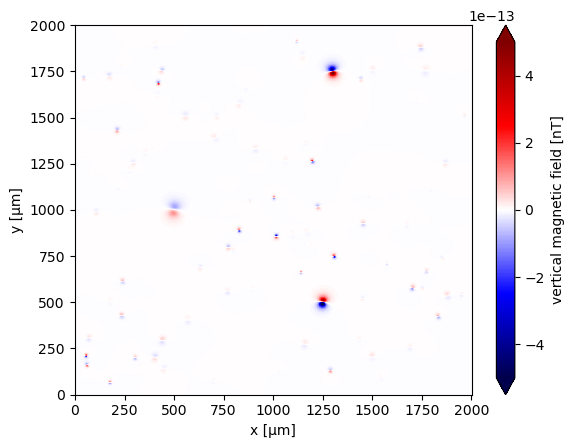

In [17]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=5000e-16, vmin=-5000e-16)